In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

from general_utils import AttrDict
from reward_induced.models.reward_predictor_model import RewardPredictorModel
from reward_induced.models.decoder import ImageDecoder
from reward_induced.utils import *
from sprites_datagen.moving_sprites import MovingSpriteDataset
from sprites_datagen.rewards import *

from tqdm import trange
import matplotlib.pyplot as plt

/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[AgentXReward, AgentYReward, TargetXReward, TargetYReward],
    )

dataset = MovingSpriteDataset(spec)

In [5]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 20  # number of conditioning frames
T_future = 10  # number of future frames to predict rewards for
batch_size = 32

lr = 1e-3
n_iter = 2_000
log_interval = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = 'complete_RPM_1e-3_1M.pth'

In [7]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Train an ImageDecoder from complete images to reward-induced representation

In [6]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [8]:
# with learned image encoder, decode reward-induced representations
encoder = model.image_encoder
print(encoder)

ImageEncoder(
  (layers): ModuleList(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)


In [9]:
decoder = ImageDecoder(image_shape)
print(decoder)

ImageDecoder(
  (layers): ModuleList(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2)
    (10): ConvTranspose2d(4, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


In [10]:
loss_fn = nn.MSELoss()
optimizer = RAdam(decoder.parameters(), lr=lr)

In [13]:
def train_decoder(encoder, decoder, dataset, device, n_iter):
    # decoder should restore the original image from the reward-induced representation
    losses = []
    encoder.to(device).eval()
    decoder.to(device)
    print(f'[INFO] Train decoder on device: {device} ...')

    for itr in trange(n_iter):
        images, _ = generate_batch(dataset, batch_size, itr)
        images = images.to(device)
		
        # encode the images
        with torch.no_grad():
            encoded_repr = encoder(images).detach()
            # print(f"""[INFO] Encoded representation shape: {encoded_repr.shape}, 
            #       max: {encoded_repr.max()}, min: {encoded_repr.min()}""") 
        
        # decode the images
        decoded_images = decoder(encoded_repr)
        # print(f"""[INFO] Decoded images shape: {decoded_images.shape}, 
        #       max: {decoded_images.max()}, min: {decoded_images.min()}""")
        # # break

        # print(f"""[INFO] Original images shape: {images.shape},
        #         max: {images.max()}, min: {images.min()}""")

        loss = loss_fn(decoded_images, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (itr+1) % log_interval == 0:
            print(f'[{itr+1} / {n_iter}] Reproduction loss: {loss.item()}')

    return losses

In [14]:
losses_decoder = train_decoder(encoder, decoder, dataset, device, n_iter)

[INFO] Train decoder on device: cuda ...


  5%|▌         | 100/2000 [00:51<17:39,  1.79it/s]

[100 / 2000] Reproduction loss: 0.8953428864479065


 10%|█         | 200/2000 [01:47<16:42,  1.80it/s]

[200 / 2000] Reproduction loss: 0.41494354605674744


 15%|█▌        | 300/2000 [02:41<15:06,  1.87it/s]

[300 / 2000] Reproduction loss: 0.2705371379852295


 20%|██        | 400/2000 [03:35<14:41,  1.82it/s]

[400 / 2000] Reproduction loss: 0.2418030947446823


 25%|██▌       | 500/2000 [04:33<14:42,  1.70it/s]

[500 / 2000] Reproduction loss: 0.22894681990146637


 30%|███       | 600/2000 [05:29<13:00,  1.79it/s]

[600 / 2000] Reproduction loss: 0.2223896086215973


 35%|███▌      | 700/2000 [06:24<12:01,  1.80it/s]

[700 / 2000] Reproduction loss: 0.21781237423419952


 40%|████      | 800/2000 [07:19<12:16,  1.63it/s]

[800 / 2000] Reproduction loss: 0.21445856988430023


 45%|████▌     | 900/2000 [08:14<11:30,  1.59it/s]

[900 / 2000] Reproduction loss: 0.20886826515197754


 50%|█████     | 1000/2000 [09:11<08:46,  1.90it/s]

[1000 / 2000] Reproduction loss: 0.20297332108020782


 55%|█████▌    | 1100/2000 [10:06<08:35,  1.75it/s]

[1100 / 2000] Reproduction loss: 0.19578582048416138


 60%|██████    | 1200/2000 [11:00<06:45,  1.97it/s]

[1200 / 2000] Reproduction loss: 0.190024733543396


 65%|██████▌   | 1300/2000 [11:52<06:42,  1.74it/s]

[1300 / 2000] Reproduction loss: 0.18107055127620697


 70%|███████   | 1400/2000 [12:49<05:24,  1.85it/s]

[1400 / 2000] Reproduction loss: 0.17787005007266998


 75%|███████▌  | 1500/2000 [13:44<04:27,  1.87it/s]

[1500 / 2000] Reproduction loss: 0.1698814481496811


 80%|████████  | 1600/2000 [14:39<03:46,  1.76it/s]

[1600 / 2000] Reproduction loss: 0.16603706777095795


 85%|████████▌ | 1700/2000 [15:35<02:42,  1.84it/s]

[1700 / 2000] Reproduction loss: 0.16281159222126007


 90%|█████████ | 1800/2000 [16:33<01:40,  1.98it/s]

[1800 / 2000] Reproduction loss: 0.15845629572868347


 95%|█████████▌| 1900/2000 [17:28<00:52,  1.90it/s]

[1900 / 2000] Reproduction loss: 0.15443538129329681


100%|██████████| 2000/2000 [18:23<00:00,  1.81it/s]

[2000 / 2000] Reproduction loss: 0.15037396550178528


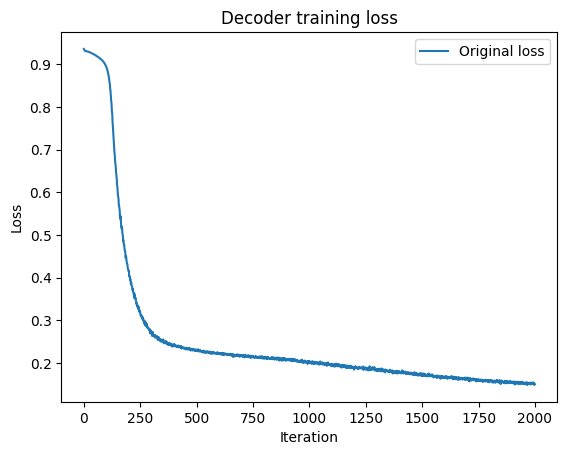

In [15]:
# Visualize the losses
# window_size = 20
# ma_losses = moving_average(losses_decoder, window_size)

plt.plot(losses_decoder, label='Original loss')
# plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Decoder training loss')
plt.legend()
plt.show()

In [21]:
PATH = 'complete_decoder_wo_tanh.pth'
torch.save(decoder.state_dict(), PATH)

In [22]:
decoder = ImageDecoder(image_shape)
decoder.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

# Decode the reward-induced representation

In [27]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=2,      # number of shapes per trajectory
        rewards=[AgentXReward, AgentYReward, TargetXReward, TargetYReward],
    )

dataset = MovingSpriteDataset(spec)

### Decode vertical reward-induced representations with ImageDecoder

In [ ]:
model_vertical = RewardPredictorModel(image_shape, n_frames, T_future)
model_vertical.load_state_dict(torch.load(PATH))

decoder_vertical = ImageDecoder(image_shape)
decoder_vertical.load_state_dict(torch.load(PATH))

In [ ]:
loss_fn = nn.MSELoss()
optimizer = RAdam(decoder.parameters(), lr=lr)

In [ ]:
def finetune_RPM_single_reward(model, dataset, loss_fn, optimizer, device, reward_type):
	losses = []
	model.to(device)
	print(f'[INFO] Finetune RPM with {reward_type} reward on device: {device} ...')

	for itr in trange(n_iter):
		images, rewards = generate_batch(dataset, batch_size, itr)
		
		# assume n_frames + T_future == len(images)
		pred_rewards = model(  # add batch dimension for images
			conditioning_frames=images[:, :n_frames].to(device), 
			future_frames=images[:, n_frames:].to(device),
			reward_type=reward_type
		)

		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = torch.tensor(rewards[reward_type][:, n_frames:], 
						 dtype=torch.float32, device=device)
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [ ]:
finetune_RPM_single_reward(model, dataset, loss_fn, optimizer, device, 'agent_x')

### Decode horizontal reward-induced representations with ImageDecoder